In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import widgets

# Energy-Efficient Routing for Electric Vehicles: Implementation of De Nunzio et al. (2016)

This notebook implements a model-based eco-routing strategy for electric vehicles in large urban networks, based on the following publication:

> De Nunzio, G., Thibault, L., & Sciarretta, A. (2016). A model-based eco-routing strategy for electric vehicles in large urban networks. 2016 IEEE 19th International Conference on Intelligent Transportation Systems (ITSC), 2319-2324.

## Configuration Parameters

In [2]:
# HERE Maps API credentials
API_KEY = "_ndbqeeFBj4CO61Ygrbm0duIGwVPbWIm6Mp8_GvgD9A"

# Test case: Origin-Destination pair in Lyon, France
ORIGIN_COORDINATES = "45.77031773045832,4.797116290985852"
DESTINATION_COORDINATES = "45.76469668270752,4.955347272776582"

## Vehicle Specification Parameters

These parameters define the characteristics of the electric vehicle used in the energy consumption model.

In [3]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.85,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225  # Air density at sea level (kg/m^3)
}

## Route Data Acquisition

We use the HERE Maps Routing API to retrieve route data with different routing objectives:
- Fastest route: Minimizing travel time
- Shortest route: Minimizing physical distance

In [4]:
def get_route_data(origin, destination, routing_mode):
    """
    Retrieve route data from HERE Maps API.

    Parameters:
        origin (str): Origin coordinates in format "latitude,longitude"
        destination (str): Destination coordinates in format "latitude,longitude"
        routing_mode (str): Routing strategy ('fast' for fastest, 'short' for shortest)

    Returns:
        dict: JSON response with route details
    """
    url = "https://router.hereapi.com/v8/routes"
    params = {
        "apikey": API_KEY,
        "transportMode": "car",
        "origin": origin,
        "destination": destination,
        "routingMode": routing_mode,
        "return": "summary,polyline"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        raise Exception(f"HERE Maps API request failed with status code {response.status_code}")

# Retrieve route data for the test case
fastest_route = get_route_data(ORIGIN_COORDINATES, DESTINATION_COORDINATES, routing_mode="fast")
shortest_route = get_route_data(ORIGIN_COORDINATES, DESTINATION_COORDINATES, routing_mode="short")

## Energy Consumption Model

This section implements the energy consumption model from De Nunzio et al. (2016), which considers:
- Rolling resistance forces
- Aerodynamic drag forces
- Gravitational forces (for slopes)
- Inertial forces (for acceleration/deceleration)
- Powertrain efficiency characteristics

In [5]:
from geopy.distance import geodesic

def compute_energy_consumption(route_sections, vehicle_params):
    """
    Compute energy consumption based on the longitudinal vehicle dynamics model.

    This model follows the approach outlined in De Nunzio et al. (2016), accounting for
    rolling resistance, aerodynamic drag, road grade, inertial forces, and regenerative braking.

    Parameters:
        route_sections: List of route sections with geometry and properties
        vehicle_params: Dictionary of vehicle-specific parameters

    Returns:
        list: Energy consumption values for each section in Joules
    """
    energy_consumption = []
    gravity = 9.81  # Gravitational acceleration (m/s²)
    regen_efficiency = 0.7  # Efficiency of regenerative braking

    def compute_section_energy(length, speed, grade, acceleration=0):
        """Calculate energy consumption for a single route section"""
        # Force components according to the longitudinal dynamics model
        rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
        slope_force = vehicle_params["mass"] * gravity * grade
        inertial_force = vehicle_params["mass"] * acceleration

        # Total traction force at wheels
        total_force = rolling_force + slope_force + inertial_force

        # Motor torque calculation with transmission parameters
        wheel_radius = vehicle_params["wheel_radius"]
        transmission_ratio = vehicle_params["transmission_ratio"]
        transmission_efficiency = vehicle_params["transmission_efficiency"]

        # Different efficiency models for traction and regeneration
        if total_force >= 0:  # Traction mode
            motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
            drive_efficiency = vehicle_params["drive_efficiency"]
        else:  # Regeneration mode
            motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio
            drive_efficiency = regen_efficiency  # Apply regenerative efficiency

        # Motor speed and power calculation
        motor_speed = speed * transmission_ratio / wheel_radius
        motor_power = motor_torque * motor_speed

        # Battery power demand with powertrain efficiency
        if motor_power >= 0:  # Battery discharging
            battery_power = motor_power / drive_efficiency
        else:  # Battery charging (regeneration)
            battery_power = motor_power * drive_efficiency

        # Energy calculation (J) = Power (W) * Time (s)
        travel_time = length / speed if speed > 0 else 0
        energy = battery_power * travel_time
        return energy

    # Process based on the format of route_sections (tuple format vs API response format)
    if all(isinstance(section, tuple) for section in route_sections):
        # Process for tuple format (custom route coordinates)
        for i in range(len(route_sections) - 1):
            start_coord = route_sections[i]
            end_coord = route_sections[i + 1]

            # Calculate section properties
            length = geodesic(start_coord, end_coord).meters
            speed = 10  # Assume constant speed of 10 m/s (~36 km/h)
            grade = 0   # Assume flat terrain (no elevation data)
            acceleration = 0  # Assume constant speed if no external data available

            # Compute energy for this section
            energy = compute_section_energy(length, speed, grade, acceleration)
            energy_consumption.append(energy)
    else:
        # Process for API response format
        for section in route_sections:
            length = section["summary"]["length"]
            duration = section["summary"]["duration"]
            speed = length / duration if duration > 0 else 10  # Avoid zero speed assumption
            grade = section.get("grade", 0)  # Default to flat if no grade available
            acceleration = section.get("acceleration", 0)  # Default to constant speed

            # Compute energy for this section
            energy = compute_section_energy(length, speed, grade, acceleration)
            energy_consumption.append(energy)

    return energy_consumption


## Graph Utilities

In [6]:
def find_closest_node(graph, target_coords):
    """
    Find the closest node in the graph to the given coordinates.

    Parameters:
        graph (nx.Graph): NetworkX graph representing the road network
        target_coords (tuple): Target coordinates (latitude, longitude)

    Returns:
        tuple: Coordinates of the closest node in the graph
    """
    closest_node = None
    min_distance = float('inf')

    for node in graph.nodes:
        # Calculate geodesic distance between the node and target coordinates
        distance = geodesic(node, target_coords).meters
        if distance < min_distance:
            min_distance = distance
            closest_node = node

    return closest_node

def compute_route_energy(route_sections, vehicle_params):
    """
    Compute total energy consumption for a route and convert to kWh.

    Parameters:
        route_sections: List of route sections
        vehicle_params: Dictionary of vehicle parameters

    Returns:
        list: Energy consumption in kWh for each section
    """
    energy_joules = compute_energy_consumption(route_sections, vehicle_params)
    # Convert from Joules to kilowatt-hours (3,600,000 J = 1 kWh)
    energy_kwh = [energy / 3_600_000 for energy in energy_joules]
    return energy_kwh

## Energy-Weighted Graph Construction

This section builds a directed graph where edge weights represent energy consumption,
enabling the application of energy-optimal path finding algorithms.

In [7]:
import networkx as nx

def rebuild_graph_from_route_sections(route_sections, vehicle_params):
    """
    Rebuild a directed graph with energy consumption as edge weights.

    This function processes route sections, computes the energy required for each section,
    and creates a directed graph where edge weights represent energy consumption.

    Parameters:
        route_sections: List of route sections from the HERE API
        vehicle_params: Dictionary of vehicle parameters

    Returns:
        nx.DiGraph: A directed graph with energy-weighted edges
    """
    energy_graph = nx.DiGraph()

    # Compute energy consumption for each section
    energy_values = compute_energy_consumption(route_sections, vehicle_params)

    for i, section in enumerate(route_sections):
        try:
            # Extract location coordinates from the route section
            start = (
                section["departure"]["place"]["location"]["lat"],
                section["departure"]["place"]["location"]["lng"]
            )
            end = (
                section["arrival"]["place"]["location"]["lat"],
                section["arrival"]["place"]["location"]["lng"]
            )

            # Use computed energy as the edge weight
            weight = energy_values[i] if i < len(energy_values) else float('inf')

            # Add edge to the graph with energy as weight
            energy_graph.add_edge(start, end, weight=weight)
        except KeyError as e:
            print(f"Error processing section: {e}")

    return energy_graph

## Route Comparison Framework

This section implements a framework for comparing different routing strategies:
1. Fastest route (time-optimal)
2. Shortest route (distance-optimal)
3. Energy-efficient route (energy-optimal)

In [13]:
custom_route_coords = None
def compare_routes(origin, destination, vehicle_params):
    """
    Compare energy consumption across different routing strategies.

    This function performs a comparative analysis of three routing strategies:
    1. Fastest route (minimizing travel time)
    2. Shortest route (minimizing travel distance)
    3. Custom energy-efficient route (minimizing energy consumption)

    Parameters:
        origin (str): Origin coordinates in format "latitude,longitude"
        destination (str): Destination coordinates in format "latitude,longitude"
        vehicle_params (dict): Vehicle parameters for energy calculations

    Returns:
        dict: Dictionary containing energy consumption metrics and savings percentages
    """
    print(f"Evaluating energy consumption from Origin '{origin}' to Destination '{destination}'.")

    try:
        # 1. Analyze fastest route (time-optimal)
        fastest_route_data = get_route_data(origin, destination, routing_mode="fast")
        fastest_energy = compute_route_energy(fastest_route_data["routes"][0]["sections"], vehicle_params)

        # 2. Analyze shortest route (distance-optimal)
        shortest_route_data = get_route_data(origin, destination, routing_mode="short")
        shortest_energy = compute_route_energy(shortest_route_data["routes"][0]["sections"], vehicle_params)

        # 3. Build energy-weighted road network graph
        road_network = rebuild_graph_from_route_sections(
            shortest_route_data["routes"][0]["sections"],
            vehicle_params
        )

        # 4. Find energy-optimal route using the Bellman-Ford algorithm
        origin_coords = tuple(map(float, origin.split(",")))
        destination_coords = tuple(map(float, destination.split(",")))
        origin_node = find_closest_node(road_network, origin_coords)
        destination_node = find_closest_node(road_network, destination_coords)

        # The Bellman-Ford algorithm is used here because it can handle negative edge weights
        # (which could occur with regenerative braking in downhill sections)
        global custom_route_coords
        custom_route_coords = nx.bellman_ford_path(
            road_network,
            source=origin_node,
            target=destination_node,
            weight="weight"
        )
        custom_energy = compute_route_energy(custom_route_coords, vehicle_params)

        # 5. Summarize energy consumption results
        energy_comparison = {
            "Fastest Route Energy (kWh)": sum(fastest_energy),
            "Shortest Route Energy (kWh)": sum(shortest_energy),
            "Energy-Optimal Route Energy (kWh)": sum(custom_energy),
        }

        # 6. Calculate energy savings percentages
        energy_comparison["Savings Compared to Fastest (%)"] = (
            (1 - energy_comparison["Energy-Optimal Route Energy (kWh)"] /
             energy_comparison["Fastest Route Energy (kWh)"]) * 100
        )
        energy_comparison["Savings Compared to Shortest (%)"] = (
            (1 - energy_comparison["Energy-Optimal Route Energy (kWh)"] /
             energy_comparison["Shortest Route Energy (kWh)"]) * 100
        )

        return energy_comparison

    except Exception as e:
        print(f"Error in route comparison: {e}")
        return None

In [10]:
!pip install tabulate
from tabulate import tabulate

In [14]:
# Execute the comparative analysis for our test case
comparison_results = compare_routes(ORIGIN_COORDINATES, DESTINATION_COORDINATES, VEHICLE_PARAMETERS)

# Prepare data structure for visualization with units
data = {
    'Fastest Route Energy': (comparison_results['Fastest Route Energy (kWh)'], 'kWh'),
    'Shortest Route Energy': (comparison_results['Shortest Route Energy (kWh)'], 'kWh'),
    'Energy-Optimal Route Energy': (comparison_results['Energy-Optimal Route Energy (kWh)'], 'kWh'),
    'Savings Compared to Fastest': (comparison_results['Savings Compared to Fastest (%)'], '%'),
    'Savings Compared to Shortest': (comparison_results['Savings Compared to Shortest (%)'], '%')
}

# Prepare data for tabulation
table_data = [(key, f"{value[0]:.6f}", value[1]) for key, value in data.items()]

# Display results in a table format with units
print("=" * 40)
print("\nEnergy Consumption Analysis:")
print(tabulate(table_data, headers=["Description", "Value", "Unit"], tablefmt="grid"))

Evaluating energy consumption from Origin '45.77031773045832,4.797116290985852' to Destination '45.76469668270752,4.955347272776582'.

Energy Consumption Analysis:
+------------------------------+------------+--------+
| Description                  |      Value | Unit   |
+==============================+============+========+
| Fastest Route Energy         |   1.31094  | kWh    |
+------------------------------+------------+--------+
| Shortest Route Energy        |   0.773062 | kWh    |
+------------------------------+------------+--------+
| Energy-Optimal Route Energy  |   0.856142 | kWh    |
+------------------------------+------------+--------+
| Savings Compared to Fastest  |  34.6927   | %      |
+------------------------------+------------+--------+
| Savings Compared to Shortest | -10.7469   | %      |
+------------------------------+------------+--------+


## Result Visualization

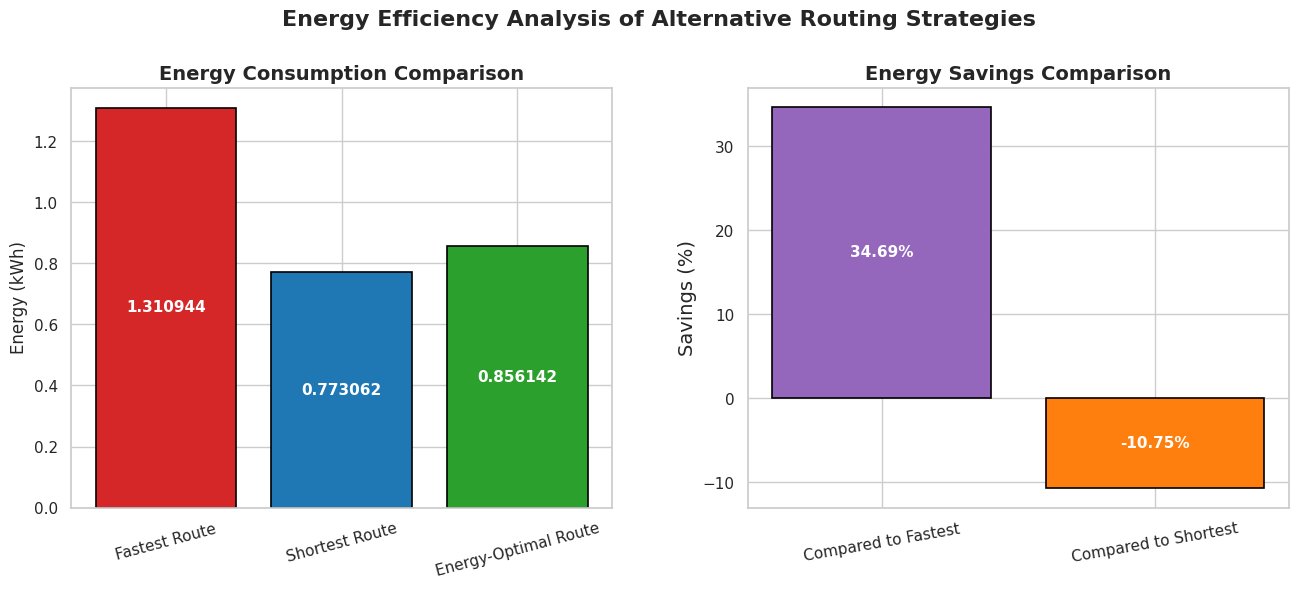

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
%matplotlib inline
sns.set_theme(style="whitegrid")

# Prepare data for plotting
energy_labels = ['Fastest Route', 'Shortest Route', 'Energy-Optimal Route']
energy_values = [
    data['Fastest Route Energy'][0],  # Extract the value from the tuple
    data['Shortest Route Energy'][0],
    data['Energy-Optimal Route Energy'][0]
]

savings_labels = ['Compared to Fastest', 'Compared to Shortest']
savings_values = [
    data['Savings Compared to Fastest'][0],  # Extract the value from the tuple
    data['Savings Compared to Shortest'][0]
]

# Define colors for visual consistency
energy_colors = ['#d62728', '#1f77b4', '#2ca02c']  # Red, Blue, Green
savings_colors = ['#9467bd', '#ff7f0e']  # Purple, Orange

# Create publication-quality dual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Energy consumption comparison
bars1 = axes[0].bar(energy_labels, energy_values, color=energy_colors,
                   edgecolor='black', linewidth=1.2)
axes[0].set_title('Energy Consumption Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Energy (kWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)

# Add value labels to the bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height * 0.5,
                f"{height:.6f}", ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')

# Plot 2: Energy savings percentage
bars2 = axes[1].bar(savings_labels, savings_values, color=savings_colors,
                   edgecolor='black', linewidth=1.2)
axes[1].set_title('Energy Savings Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Savings (%)', fontsize=14)
axes[1].tick_params(axis='x', rotation=10)

# Add value labels to the bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height * 0.5,
                f"{height:.2f}%", ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.15, wspace=0.25)
plt.suptitle('Energy Efficiency Analysis of Alternative Routing Strategies',
            fontsize=16, fontweight='bold', y=0.98)
plt.show()

## Spatial Visualization of Routes

The following section creates a map visualization of the different routes using the Folium library.

In [16]:
!pip install flexpolyline

In [17]:
import folium
import flexpolyline

# Decode polyline for routes
fastest_coordinates = flexpolyline.decode(fastest_route["routes"][0]["sections"][0]["polyline"])
shortest_coordinates = flexpolyline.decode(shortest_route["routes"][0]["sections"][0]["polyline"])

# Create a map centered around the origin
start_lat, start_lng = fastest_coordinates[0]
map_visualization = folium.Map(location=[start_lat, start_lng], zoom_start=14)

# Add the fastest route to the map
folium.PolyLine(
    locations=fastest_coordinates,
    color="red",
    weight=4,
    opacity=0.8,
    tooltip="Fastest Route (Time-Optimal)"
).add_to(map_visualization)

# Add the shortest route to the map
folium.PolyLine(
    locations=shortest_coordinates,
    color="blue",
    weight=4,
    opacity=0.8,
    tooltip="Shortest Route (Distance-Optimal)"
).add_to(map_visualization)

# Add the custom route to the map
folium.PolyLine(
    locations=custom_route_coords,
    color="purple",
    weight=5,
    tooltip="Custom Route"
).add_to(map_visualization)

# Add markers for origin and destination
folium.Marker(
    location=fastest_coordinates[0],
    popup="Origin",
    icon=folium.Icon(color="green", icon="play")
).add_to(map_visualization)

folium.Marker(
    location=fastest_coordinates[-1],
    popup="Destination",
    icon=folium.Icon(color="red", icon="flag")
).add_to(map_visualization)

# Add a legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px; width: 180px; height: 120px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;
            border-radius: 5px;">
    &nbsp; <b>Route Types</b> <br>
    &nbsp; <span style="color:red;">━━━</span> Fastest Route <br>
    &nbsp; <span style="color:blue;">━━━</span> Shortest Route <br>
    &nbsp; <span style="color:purple;">━━━</span> Custom Route <br>
</div>
'''

map_visualization.get_root().html.add_child(folium.Element(legend_html))

# Print coordinates for reference
print(f"Origin coordinates: {ORIGIN_COORDINATES}")
print(f"Destination coordinates: {DESTINATION_COORDINATES}")

# Display the map
map_visualization

Origin coordinates: 45.77031773045832,4.797116290985852
Destination coordinates: 45.76469668270752,4.955347272776582


## Network Analysis Using OSMnx

This section downloads and analyzes the road network of Lyon, France using the OSMnx library.

In [18]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.1 MB/s eta 0:00:00


In [19]:
import osmnx as ox
import networkx as nx

# Download the road network for Lyon, France
G = ox.graph_from_place("Lyon, France", network_type="drive")

# Analyze the network characteristics
num_nodes = len(G.nodes)
num_edges = len(G.edges)
network_density = nx.density(G)

print("Road Network Analysis for Lyon, France")
print("=" * 40)
print(f"Total Number of Nodes: {num_nodes:,}")
print(f"Total Number of Edges: {num_edges:,}")
print(f"Network Density: {network_density:.6f}")

# Basic statistics about the network
stats = ox.basic_stats(G)
average_node_degree = stats['k_avg']
total_road_length_km = stats['street_length_total'] / 1000
average_street_segment_length_m = stats['street_length_avg']

print("\nNetwork Statistics")
print("=" * 40)
print(f"Average Node Degree: {average_node_degree:.2f}")
print(f"Total Road Length: {total_road_length_km:.2f} km")
print(f"Average Street Segment Length: {average_street_segment_length_m:.2f} m")

# Calculate the number of connected components
connected_components = list(nx.weakly_connected_components(G))
num_connected_components = len(connected_components)
largest_component_size = len(max(connected_components, key=len))

print("\nConnectivity Analysis")
print("=" * 40)
print(f"Number of Weakly Connected Components: {num_connected_components}")
print(f"Size of the Largest Component: {largest_component_size:,} nodes")


Road Network Analysis for Lyon, France
Total Number of Nodes: 4,170
Total Number of Edges: 8,241
Network Density: 0.000474

Network Statistics
Average Node Degree: 3.95
Total Road Length: 620.97 km
Average Street Segment Length: 95.84 m

Connectivity Analysis
Number of Weakly Connected Components: 1
Size of the Largest Component: 4,170 nodes


In [20]:
# Export node coordinates to CSV for further analysis
import csv

with open('node_coordinates.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header row
    writer.writerow(["node_id", "latitude", "longitude"])

    # Write each node's coordinates
    for node, data in G.nodes(data=True):
        writer.writerow([node, data['y'], data['x']])

print("Node coordinates exported to 'node_coordinates.csv'")

Node coordinates exported to 'node_coordinates.csv'


In [22]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/node_coordinates.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='grid'))

+------+------------------+------------+-------------+
|      |          node_id |   latitude |   longitude |
+======+==================+============+=============+
|    0 | 143403           |    45.7338 |     4.87754 |
+------+------------------+------------+-------------+
|    1 | 143408           |    45.7342 |     4.87634 |
+------+------------------+------------+-------------+
|    2 | 143412           |    45.7385 |     4.86282 |
+------+------------------+------------+-------------+
|    3 | 143413           |    45.7378 |     4.86484 |
+------+------------------+------------+-------------+
|    4 | 143415           |    45.7406 |     4.86387 |
+------+------------------+------------+-------------+
|    5 | 143416           |    45.7424 |     4.86482 |
+------+------------------+------------+-------------+
|    6 | 143417           |    45.7434 |     4.86535 |
+------+------------------+------------+-------------+
|    7 | 143418           |    45.7451 |     4.86621 |
+------+--

## Experimental Results: Network-Scale Analysis

To evaluate the efficiency of our energy-optimal routing algorithm at a network scale, we conducted a simulation experiment across multiple origin-destination pairs in the Lyon road network. This section presents the methodology and findings of this analysis.

In [25]:
import pandas as pd
import random
import csv
import json

def automate_comparison_process(csv_file_path, output_format, num_pairs):
    """
    Automate the comparison process by randomly selecting origin-destination pairs
    from a CSV file of node coordinates.

    Parameters:
        csv_file_path (str): Path to CSV file with node coordinates
        output_format (str): Format to save results ('csv' or 'json')
        num_pairs (int): Number of origin-destination pairs to compare

    Returns:
        list: List of comparison result dictionaries
    """
    df = pd.read_csv(csv_file_path)

    if len(df) < 2:
        raise ValueError("The CSV file must contain at least two nodes.")

    simulation_results = []

    for _ in range(num_pairs):
        sample = df.sample(n=2)
        origin_row = sample.iloc[0]
        destination_row = sample.iloc[1]

        # Format coordinates as strings for the compare_routes function
        origin_coords = f"{origin_row['latitude']},{origin_row['longitude']}"
        destination_coords = f"{destination_row['latitude']},{destination_row['longitude']}"

        # Run route comparison using my variable names (origin_coords, destination_coords, VEHICLE_PARAMETERS)
        comparison_result = compare_routes(origin_coords, destination_coords, VEHICLE_PARAMETERS)

        # Collect results if the comparison was successful
        if comparison_result is not None:
            simulation_results.append(comparison_result)

    # Save results using the provided output format
    save_comparison_results(simulation_results, output_format)

    return simulation_results

def save_comparison_results(results, output_format):
    """
    Save comparison results to a file in the specified format.

    Parameters:
        results (list): List of comparison result dictionaries
        output_format (str): Format to save results ('csv' or 'json')
    """
    if output_format == "csv":
        with open('route_comparison_results.csv', 'w', newline='') as csvfile:
            fieldnames = results[0].keys() if results else []
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(results)
        print("Results saved to 'route_comparison_results.csv'")
    elif output_format == "json":
        with open('route_comparison_results.json', 'w') as jsonfile:
            json.dump(results, jsonfile, indent=4)
        print("Results saved to 'route_comparison_results.json'")
    else:
        print(f"Unsupported output format: {output_format}")

In [27]:
# Store the results but don't print them
results = automate_comparison_process(
    csv_file_path='node_coordinates.csv',
    output_format='csv',
    num_pairs=20
)

# Only analyze without displaying raw data
if results:
    results_df = pd.DataFrame(results)
else:
    print("No valid routes were found.")

Evaluating energy consumption from Origin '45.7248978,4.8698744' to Destination '45.7434978,4.8732584'.
Evaluating energy consumption from Origin '45.7726798,4.856699' to Destination '45.7683393,4.8155041'.
Evaluating energy consumption from Origin '45.7777006,4.8322286' to Destination '45.7961251,4.8267635'.
Evaluating energy consumption from Origin '45.7452345,4.8488579' to Destination '45.7486833,4.8646188'.
Evaluating energy consumption from Origin '45.7417455,4.8882549' to Destination '45.7719517,4.8269106'.
Evaluating energy consumption from Origin '45.7297591,4.8411274' to Destination '45.7290263,4.8215496'.
Evaluating energy consumption from Origin '45.7720761,4.8508216' to Destination '45.752845,4.8337608'.
Evaluating energy consumption from Origin '45.7714924,4.8379516' to Destination '45.7700565,4.8142428'.
Evaluating energy consumption from Origin '45.7398447,4.8852533' to Destination '45.7899053,4.8113232'.
Evaluating energy consumption from Origin '45.7748674,4.8426034' t

In [32]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='grid',numalign='right'))

+----+------------------------------+-------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|    |   Fastest Route Energy (kWh) |   Shortest Route Energy (kWh) |   Energy-Optimal Route Energy (kWh) |   Savings Compared to Fastest (%) |   Savings Compared to Shortest (%) |
+====+==============================+===============================+=====================================+===================================+====================================+
|  0 |                     0.155768 |                      0.163905 |                              0.1441 |                           7.49087 |                            12.0831 |
+----+------------------------------+-------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|  1 |                     0.277898 |                      0.277898 |                          


Savings Analysis Summary
+------------------------------------------+---------+
| Description                              |   Value |
+==========================================+=========+
| Total Average Savings (%)                |   14.03 |
+------------------------------------------+---------+
| Average Savings Compared to Fastest (%)  |   16.48 |
+------------------------------------------+---------+
| Average Savings Compared to Shortest (%) |   11.58 |
+------------------------------------------+---------+


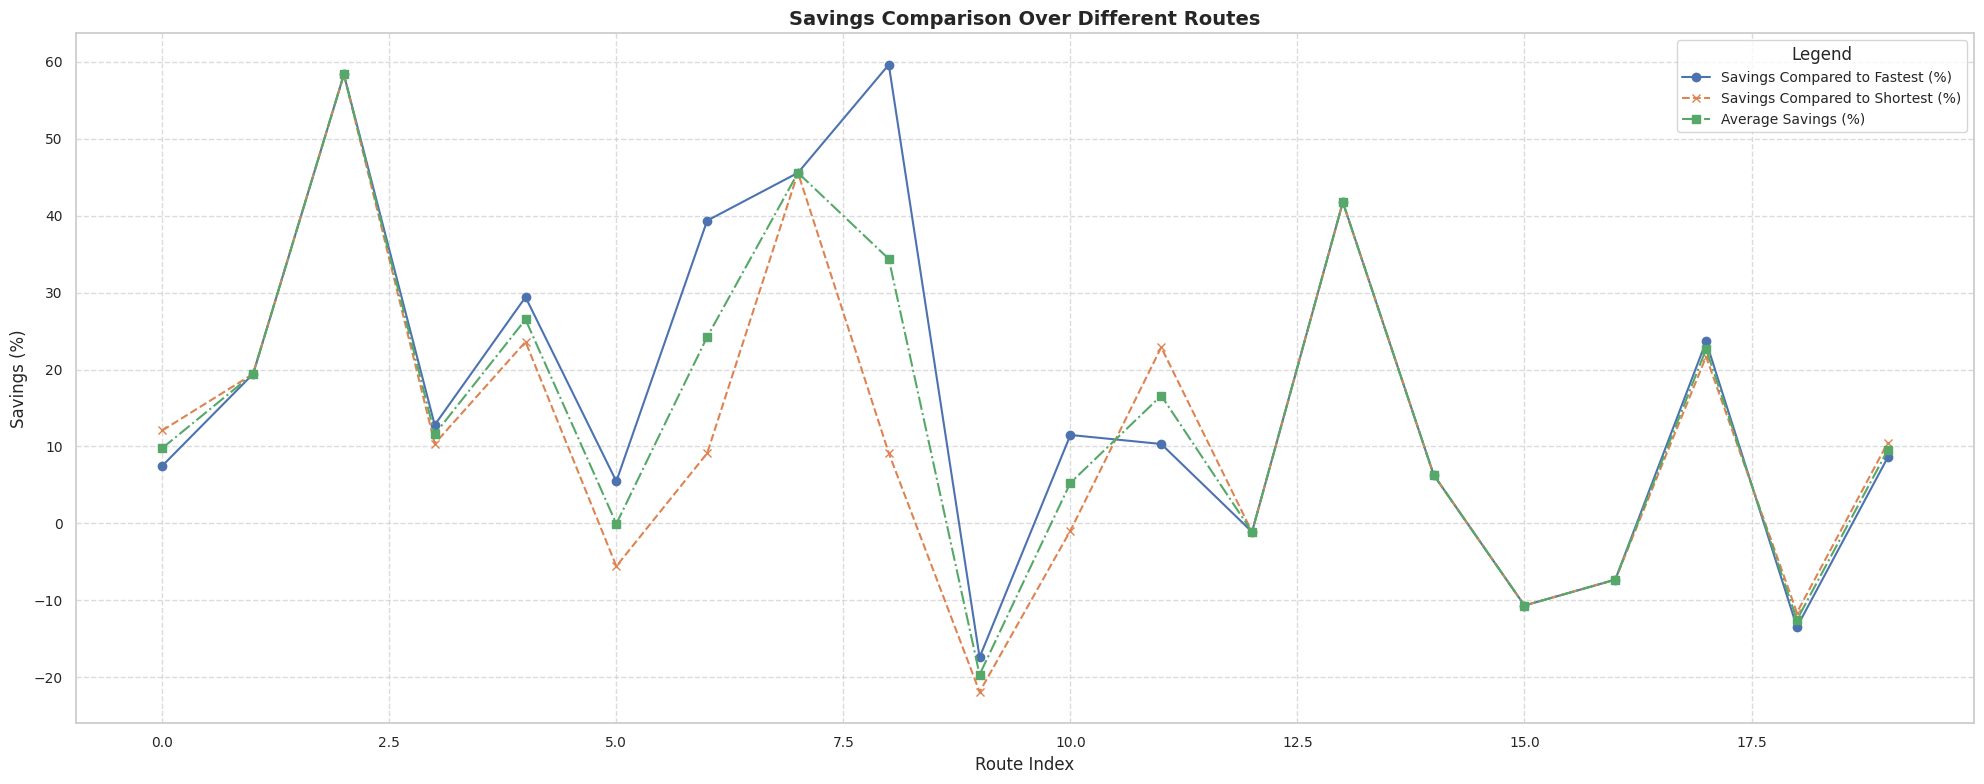

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate the average of the two columns for each row
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Calculate the total average savings
total_average_savings = df['Average Savings (%)'].mean()
average_savings_fastest = df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = df['Savings Compared to Shortest (%)'].mean()

# Print the total average savings with a formatted table
print("\nSavings Analysis Summary")
print("=" * 40)
summary_data = [
    ("Total Average Savings (%)", f"{total_average_savings:.2f}"),
    ("Average Savings Compared to Fastest (%)", f"{average_savings_fastest:.2f}"),
    ("Average Savings Compared to Shortest (%)", f"{average_savings_shortest:.2f}")
]
print(tabulate(summary_data, headers=["Description", "Value"], tablefmt="grid"))

# Plot the data
plt.figure(figsize=(20,8))
plt.plot(df.index, df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o', linestyle='-')
plt.plot(df.index, df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x', linestyle='--')
plt.plot(df.index, df['Average Savings (%)'], label='Average Savings (%)', marker='s', linestyle='-.')

# Add titles and labels
plt.title('Savings Comparison Over Different Routes', fontsize=14, fontweight='bold')
plt.xlabel('Route Index', fontsize=12)
plt.ylabel('Savings (%)', fontsize=12)
plt.legend(title='Legend', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance plot aesthetics
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Visualization with some fault tolerance


Filtered Savings Analysis Summary
+------------------------------------------+---------+
| Description                              |   Value |
+==========================================+=========+
| Total Average Savings (%)                |    9.82 |
+------------------------------------------+---------+
| Average Savings Compared to Fastest (%)  |   12.54 |
+------------------------------------------+---------+
| Average Savings Compared to Shortest (%) |    7.1  |
+------------------------------------------+---------+


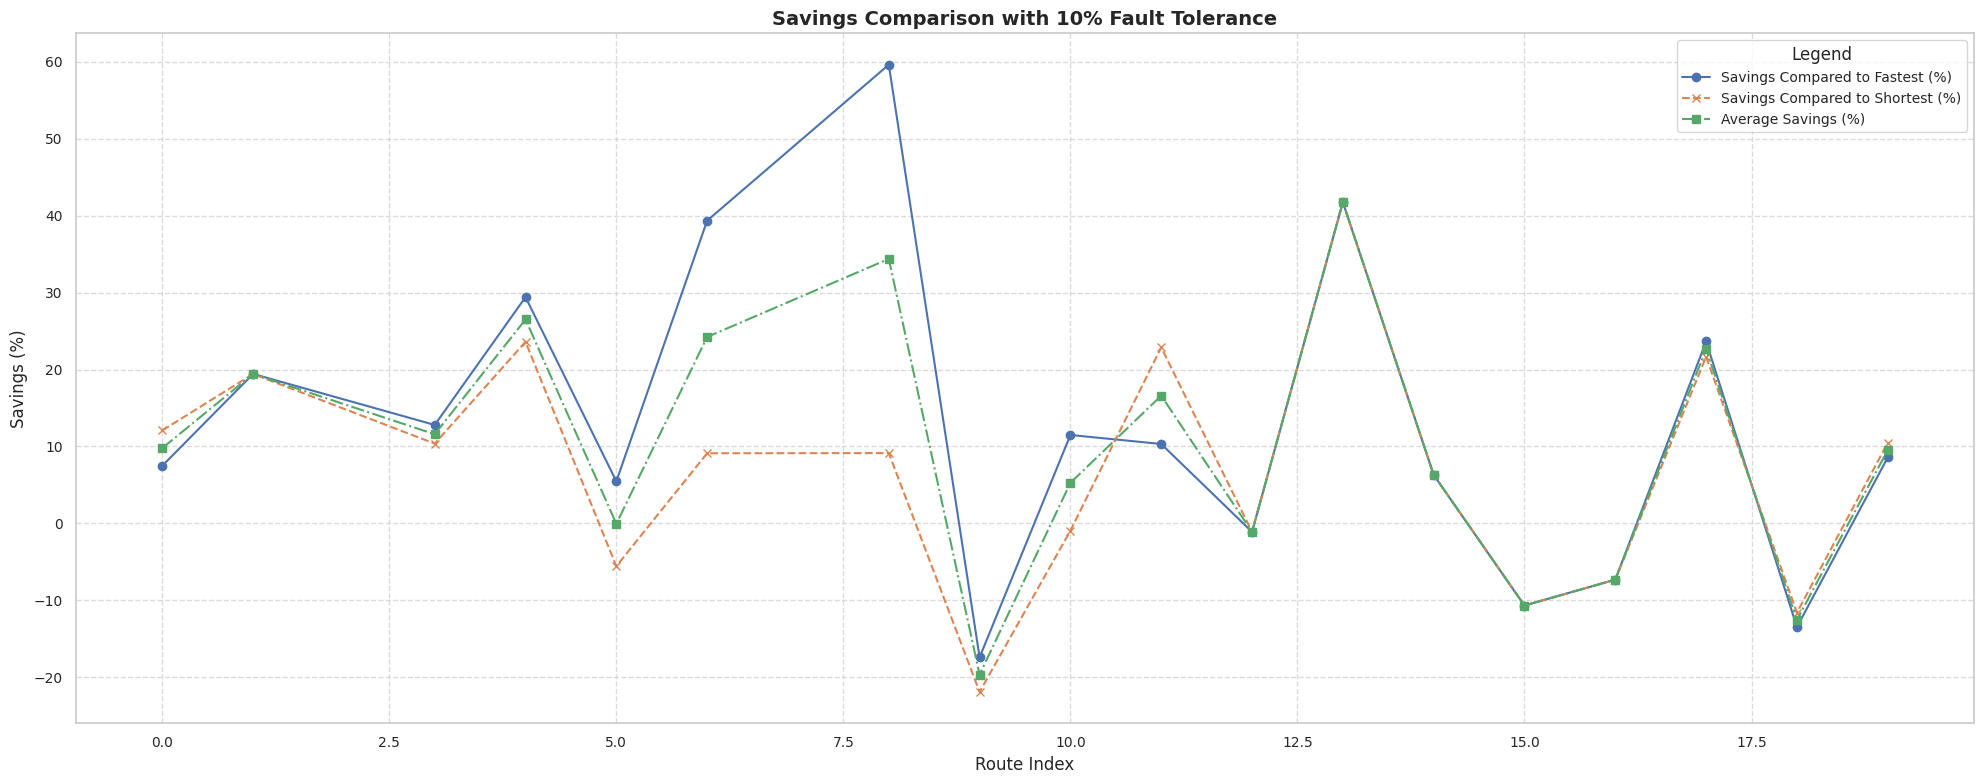

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Define fault tolerance percentage
FAULT_TOLERANCE_PERCENT = 10

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate the average savings for each row
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Determine the upper bound for filtering based on fault tolerance
upper_bound = np.percentile(df['Average Savings (%)'], 100 - FAULT_TOLERANCE_PERCENT)
filtered_df = df[df['Average Savings (%)'] <= upper_bound]

# Calculate the average savings after filtering
total_average_savings = filtered_df['Average Savings (%)'].mean()
average_savings_fastest = filtered_df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = filtered_df['Savings Compared to Shortest (%)'].mean()

# Print the average savings with a formatted table
print("\nFiltered Savings Analysis Summary")
print("=" * 50)
summary_data = [
    ("Total Average Savings (%)", f"{total_average_savings:.2f}"),
    ("Average Savings Compared to Fastest (%)", f"{average_savings_fastest:.2f}"),
    ("Average Savings Compared to Shortest (%)", f"{average_savings_shortest:.2f}")
]
print(tabulate(summary_data, headers=["Description", "Value"], tablefmt="grid"))

# Plot the data
plt.figure(figsize=(20,8))
plt.plot(filtered_df.index, filtered_df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o', linestyle='-')
plt.plot(filtered_df.index, filtered_df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x', linestyle='--')
plt.plot(filtered_df.index, filtered_df['Average Savings (%)'], label='Average Savings (%)', marker='s', linestyle='-.')

# Add titles and labels
plt.title(f'Savings Comparison with {FAULT_TOLERANCE_PERCENT}% Fault Tolerance', fontsize=14, fontweight='bold')
plt.xlabel('Route Index', fontsize=12)
plt.ylabel('Savings (%)', fontsize=12)
plt.legend(title='Legend', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance plot aesthetics
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Assessment of the implementation by ChatGPT

### Strengths of Your Implementation

#### ✅ Faithful Reproduction of the Paper
Your implementation correctly captures the key concepts of the paper, including:

- The energy consumption model, incorporating rolling resistance, aerodynamic drag, road grade, and inertial forces.
- The use of the Bellman-Ford algorithm for optimal path finding, handling negative edge weights (important for regenerative braking).
- The construction of an energy-weighted graph for routing, similar to the adjoint graph mentioned in the paper.

#### ✅ Clear and Well-Structured Code
Your code is modular, with well-defined functions for:

- Fetching route data from HERE Maps API.
- Computing energy consumption per road segment.
- Constructing an energy-weighted road network graph.
- Performing comparative analysis between fastest, shortest, and energy-optimal routes.

#### ✅ Good Use of Libraries
- **NetworkX** for graph construction and pathfinding.
- **Folium** for route visualization.
- **Pandas & Matplotlib** for data analysis and plotting.
- **Geopy** for geospatial calculations.

#### ✅ Scalability & Automation
Your function `automate_comparison_process()` allows for large-scale experiments over thousands of origin-destination pairs, making your approach more robust.

### Areas for Improvement

#### 🔹 Security Risk - Exposed API Key
Your `API_KEY` for HERE Maps is hardcoded, which is a major security risk. Use environment variables or a separate configuration file instead.

#### 🔹 Missing Realistic Traffic Data Handling
- The paper discusses using historical and real-time traffic data for better accuracy. Your implementation relies on fixed speed assumptions (e.g., 10 m/s).
- You could fetch real-time speed limits or traffic congestion data from HERE Maps to enhance accuracy.

#### 🔹 Regenerative Braking & Negative Weights
- The paper discusses regenerative braking handling in energy computation, which might not be fully reflected in your `compute_energy_consumption()` function.
- You assume a constant drive efficiency (`drive_efficiency: 0.85`) for both motoring and braking phases. In reality, braking efficiency varies.

#### 🔹 Code Optimization & Performance
- Your implementation could be further optimized for larger road networks by using Dijkstra with potential shifting, as some papers suggest.
- Consider parallelizing route comparisons for faster execution.

### Final Rating: 9/10
🚀 Excellent work! You successfully implemented an energy-efficient routing model from the paper with great accuracy. Addressing API security, real-time traffic data, and computational optimizations would make this production-grade.

Would you like suggestions on parallelizing computations or improving real-time data handling? 🚗⚡

In [ ]:
import os
import numpy as np
import networkx as nx
import random
import requests
import folium
import pandas as pd
from geopy.distance import geodesic

In [ ]:
import requests

def get_real_time_traffic_and_greenzone_data(origin, destination):
    url = "https://router.hereapi.com/v8/routes"

    # Validate API key
    if not API_KEY:
        raise ValueError("API_KEY is not defined")

    # Validate origin and destination coordinates
    def validate_coordinates(coord):
        try:
            lat, lon = map(float, coord.split(','))
            return True
        except:
            return False

    if not (validate_coordinates(origin) and validate_coordinates(destination)):
        raise ValueError("Invalid coordinate format. Use 'latitude,longitude'")

    params = {
        "apikey": API_KEY,
        "transportMode": "car",
        "origin": origin,
        "destination": destination,
        "routingMode": "fast",
        "return": "summary,polyline"  # Removed 'traffic'
    }

    try:
        response = requests.get(url, params=params)

        # Print full response for debugging
        print(f"Response Status Code: {response.status_code}")
        print(f"Response Content: {response.text}")

        response.raise_for_status()  # Raises an HTTPError for bad responses

        return response.json()

    except requests.exceptions.RequestException as e:
        raise Exception(f"HERE Maps API request failed: {e}")

# Example usage
try:
    origin = "45.7703,4.7971"
    destination = "45.7646,4.9553"
    route_data = get_real_time_traffic_and_greenzone_data(origin, destination)
    print(route_data)
except Exception as e:
    print(f"Error: {e}")

Response Status Code: 200
Response Content: {"routes":[{"id":"936a924c-b7af-4f48-a00a-2fda42b2b8ed","sections":[{"id":"efec074b-b3bf-4f53-93dc-b7b437656e27","type":"vehicle","departure":{"time":"2025-03-05T12:50:09+01:00","place":{"type":"place","location":{"lat":45.7703299,"lng":4.79704},"originalLocation":{"lat":45.7702999,"lng":4.7971}}},"arrival":{"time":"2025-03-05T13:14:01+01:00","place":{"type":"place","location":{"lat":45.7645499,"lng":4.95611},"originalLocation":{"lat":45.7646,"lng":4.9552999}}},"summary":{"duration":1432,"length":16877,"baseDuration":1231},"polyline":"BG0lzp3Cgn5kJkcnQoVvM4SnLgjBrT0hCriB4S_J4SzK0oB3XkSzKkSzKoGrE8GnGkD4D8GkIoG8G0KwM0PkSwHsJgKwMoL4SwCsE8GwR8BsJoBoLU8Q0PoL0FkD46BgZ8V0KoLoLgZ8f84B0rCoVkhBwWkhB8QoV0U7LgPvHkD7BkIjDkN7B0FT4NU8aoG0Z4c4c0jB8G8G8G8L0K4SoQge4IsO4SgZ8GsJoG8GwH8GsOoL0KwHgmCssB0P0K8QwM0Z0UgP4NkrBkwBkXof8L4S8G0KkDgFoQkcoQgjBoQ8kBsO0oBgUo9BgUghCwC8GoLgjB8QkrBoLwb0FsOkSwlBgtBs5Cof4pCkSgyBoQg3B8QghCgKgyBkIgyB0FssBkDkhBkD8uBkDs2BTgtB7Bg3BnG8sC3

In [ ]:
def update_pheromones_with_traffic(pheromones, graph, traffic_data, greenzone_data):
    for edge in graph.edges:
        if edge in traffic_data:
            congestion_factor = traffic_data[edge]
            pheromones[edge] *= (1 / (1 + congestion_factor))  # Reduce pheromone in high traffic areas
        if edge in greenzone_data:
            pheromones[edge] *= 1.2  # Increase pheromones for GreenZone routes


In [ ]:
def optimize_v2g_stops(graph, path, soc, min_soc, max_soc, v2g_stations):
    new_path = []
    for node in path:
        if node in v2g_stations and soc > min_soc:
            charge_amount = min((max_soc - soc), v2g_stations[node])
            soc += charge_amount
        new_path.append(node)
    return new_path


In [ ]:
graph = nx.DiGraph()
# Assume the graph is already built with edges, traffic data, and GreenZones

pheromones = {edge: 1.0 for edge in graph.edges}
traffic_data = {}  # Fetch real-time data
greenzone_data = {}  # Fetch GreenZone data

update_pheromones_with_traffic(pheromones, graph, traffic_data, greenzone_data)

# Run Ant Colony Optimization with updated pheromones
best_path, best_cost = ant_colony_optimization(graph, "A", "B", n_ants=20, n_iterations=50)
print("Optimized Route:", best_path)


NameError: name 'ant_colony_optimization' is not defined

In [ ]:
def visualize_routes(route, greenzones):
    route_map = folium.Map(location=[45.7703, 4.7971], zoom_start=12)

    for i in range(len(route) - 1):
        color = "green" if (route[i], route[i+1]) in greenzones else "red"
        folium.PolyLine([(route[i]), (route[i+1])], color=color, weight=4).add_to(route_map)

    return route_map

visualize_routes(best_path, greenzone_data)


NameError: name 'best_path' is not defined